In [1]:
!pip install -q torch transformers datasets matplotlib numpy pillow

In [2]:
import torch
from datasets import load_dataset
from transformers import SegGptImageProcessor, SegGptForImageSegmentation
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [3]:
def show_images_side_by_side(images, titles=None, cmap_list=None):
    """
    Display a list of images side by side in a notebook.

    Args:
        images (list): List of images (PIL or np.ndarray).
        titles (list): Optional list of titles for each subplot.
        cmap_list (list): Optional list of colormaps for each image.
    """
    n = len(images)
    plt.figure(figsize=(4 * n, 4))
    for i, img in enumerate(images):
        plt.subplot(1, n, i + 1)
        # Convert PIL image to np.ndarray if needed
        if hasattr(img, 'mode'):
            img = np.array(img)
        cmap = cmap_list[i] if cmap_list and i < len(cmap_list) else None
        plt.imshow(img, cmap=cmap)
        plt.axis('off')
        if titles and i < len(titles):
            plt.title(titles[i])
    plt.tight_layout()
    plt.show()

def show_segmentation_mask(image, mask, alpha=0.5, colormap='jet'):
    """
    Displays an image with its segmentation mask overlay.
    
    Args:
        image (PIL.Image or np.ndarray): The input image.
        mask (np.ndarray): The segmentation mask (2D array of class indices).
        alpha (float): Transparency for the mask overlay.
        colormap (str): Matplotlib colormap to use for the mask.
    """
    # Convert PIL image to numpy array if necessary
    if not isinstance(image, np.ndarray):
        image = np.array(image)
    
    # If grayscale, convert to RGB
    if image.ndim == 2:
        image = np.stack([image]*3, axis=-1)
    elif image.shape[2] == 1:
        image = np.concatenate([image]*3, axis=-1)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.imshow(mask, cmap=colormap, alpha=alpha, vmin=0)
    plt.axis('off')
    plt.show()

In [4]:
def seggpt(image, prompt_image, prompt_mask, num_labels=None):
    
    checkpoint = "BAAI/seggpt-vit-large"
    image_processor = SegGptImageProcessor.from_pretrained(checkpoint)
    model = SegGptForImageSegmentation.from_pretrained(checkpoint)
    inputs = image_processor(
        images=image, 
        prompt_images=prompt_image,
        prompt_masks=prompt_mask,
        num_labels=num_labels,
        return_tensors="pt"
    )

    with torch.no_grad():
        outputs = model(**inputs)

    target_sizes = [image.size[::-1]]
    mask = image_processor.post_process_semantic_segmentation(outputs, target_sizes, num_labels=num_labels)[0]
    return mask

In [5]:
dataset_id = "segments/sidewalk-semantic"
ds = load_dataset(dataset_id, split="train")
ds

Dataset({
    features: ['pixel_values', 'label'],
    num_rows: 1000
})

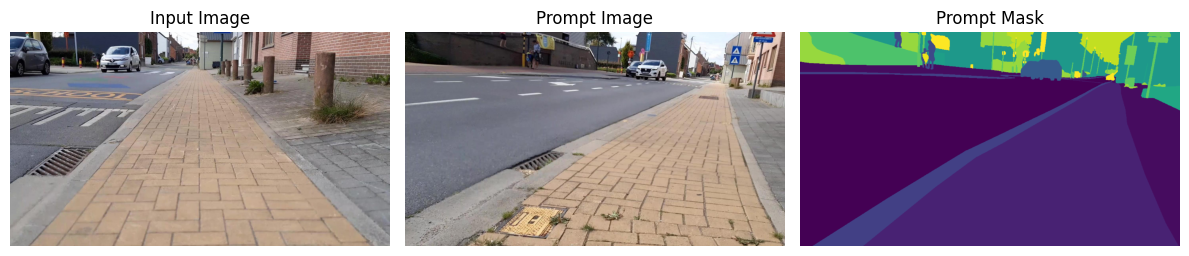

In [6]:
input_image = (ds['pixel_values'][27])
prompt_image = (ds['pixel_values'][25])
prompt_mask = (ds['label'][25])

# Usage:
show_images_side_by_side(
    [input_image, prompt_image, prompt_mask],
    titles=["Input Image", "Prompt Image", "Prompt Mask"],
    cmap_list=[None, 'jet', None, 'jet']
)

In [7]:
mask = seggpt(input_image, prompt_image, prompt_mask, num_labels=35)
mask


tensor([[ 1,  1,  1,  ..., 18, 18, 18],
        [ 1,  1,  1,  ..., 18, 18, 18],
        [ 1,  1,  1,  ..., 18, 18, 18],
        ...,
        [ 7,  7,  7,  ...,  7,  7,  7],
        [ 7,  7,  7,  ...,  7,  7,  7],
        [ 7,  7,  7,  ...,  7,  7,  7]])

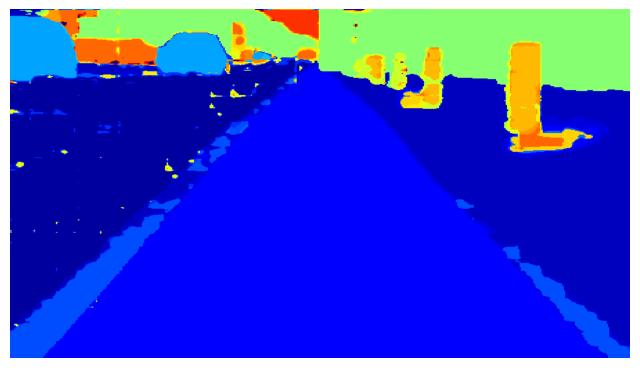

In [8]:
show_segmentation_mask(input_image, mask, alpha=1)

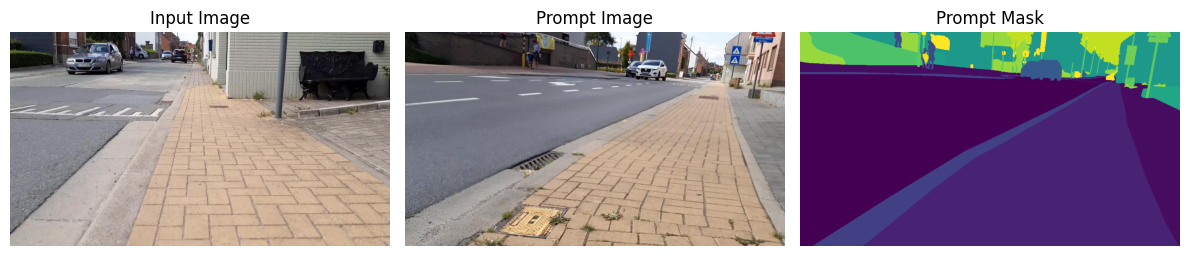

In [9]:
input_image = (ds['pixel_values'][30])
prompt_image = (ds['pixel_values'][25])
prompt_mask = (ds['label'][25])

# Usage:
show_images_side_by_side(
    [input_image, prompt_image, prompt_mask],
    titles=["Input Image", "Prompt Image", "Prompt Mask"],
    cmap_list=[None, 'jet', None, 'jet']
)

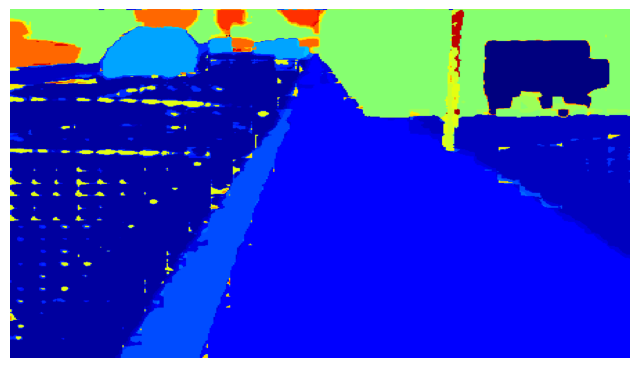

In [10]:
mask = seggpt(input_image, prompt_image, prompt_mask, num_labels=35)
show_segmentation_mask(input_image, mask, alpha=1)

In [11]:
!wget -O prompt_image.png https://i.pinimg.com/736x/50/98/13/509813d517020b225d7fabce5678c3d4.jpg
!wget -O input_image.png https://i.pinimg.com/736x/dc/78/67/dc786777b9814ffe75afc963a9e77ef7.jpg

prompt_image = Image.open("prompt_image.png").resize((512, 512))
prompt_mask = Image.open("prompt_mask.png").resize((512, 512)).convert("RGB").convert("L")
input_image = Image.open("input_image.png").resize((512, 512))


--2025-05-22 06:58:02--  https://i.pinimg.com/736x/50/98/13/509813d517020b225d7fabce5678c3d4.jpg
Resolving i.pinimg.com (i.pinimg.com)... 151.101.192.84, 151.101.128.84, 151.101.64.84, ...
Connecting to i.pinimg.com (i.pinimg.com)|151.101.192.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33153 (32K) [image/jpeg]
Saving to: ‘prompt_image.png’

prompt_image.png    100%[===================>]  32.38K  --.-KB/s    in 0.003s  

2025-05-22 06:58:02 (12.3 MB/s) - ‘prompt_image.png’ saved [33153/33153]

--2025-05-22 06:58:02--  https://i.pinimg.com/736x/dc/78/67/dc786777b9814ffe75afc963a9e77ef7.jpg
Resolving i.pinimg.com (i.pinimg.com)... 151.101.192.84, 151.101.128.84, 151.101.64.84, ...
Connecting to i.pinimg.com (i.pinimg.com)|151.101.192.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17867 (17K) [image/jpeg]
Saving to: ‘input_image.png’

input_image.png     100%[===================>]  17.45K  --.-KB/s    in 0.001s  

2025-05-22 06

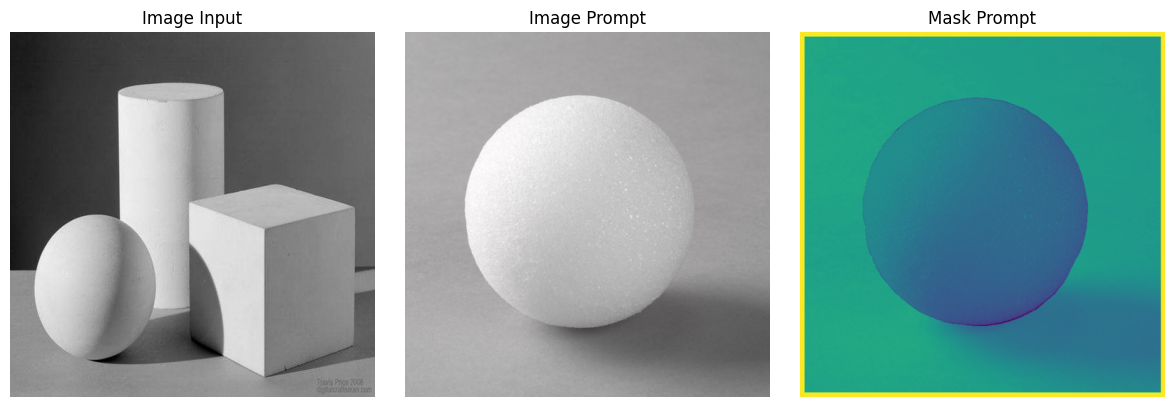

In [12]:
show_images_side_by_side(
    [input_image, prompt_image, prompt_mask],
    titles=["Image Input", "Image Prompt", "Mask Prompt"],
    cmap_list=[None, 'jet', None]
)

In [13]:
mask = seggpt(input_image, prompt_image, prompt_mask)

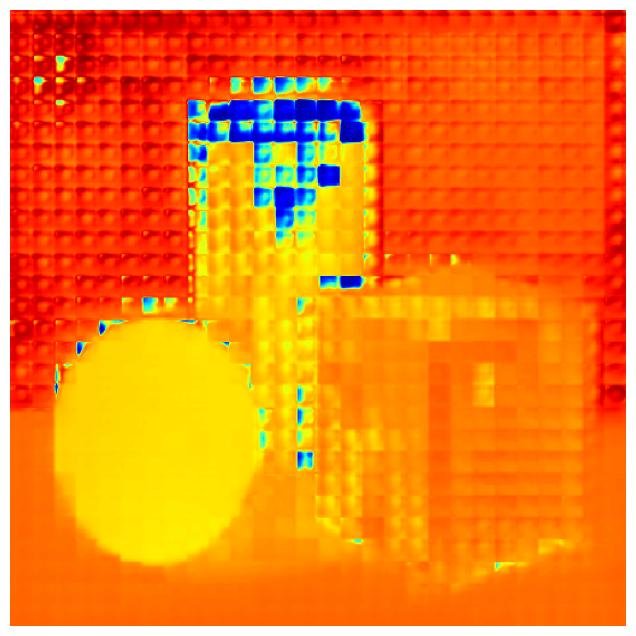

In [14]:
show_segmentation_mask(input_image, mask, alpha=1)

In [15]:
from transformers import SegGptImageProcessor, SegGptForImageSegmentation
from PIL import Image
import requests

# Load images from URLs
image_input = Image.open(requests.get("https://raw.githubusercontent.com/baaivision/Painter/main/SegGPT/SegGPT_inference/examples/hmbb_2.jpg", stream=True).raw)
image_prompt = Image.open(requests.get("https://raw.githubusercontent.com/baaivision/Painter/main/SegGPT/SegGPT_inference/examples/hmbb_1.jpg", stream=True).raw)
mask_prompt = Image.open(requests.get("https://raw.githubusercontent.com/baaivision/Painter/main/SegGPT/SegGPT_inference/examples/hmbb_1_target.png", stream=True).raw).convert("L")

# Initialize model and processor
checkpoint = "BAAI/seggpt-vit-large"
model = SegGptForImageSegmentation.from_pretrained(checkpoint)
image_processor = SegGptImageProcessor.from_pretrained(checkpoint)

# Process images and generate segmentation
inputs = image_processor(images=image_input, prompt_images=image_prompt, prompt_masks=mask_prompt, return_tensors="pt")
outputs = model(**inputs)

# Post-process to get final segmentation mask
result = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[(image_input.height, image_input.width)])
mask = result[0]

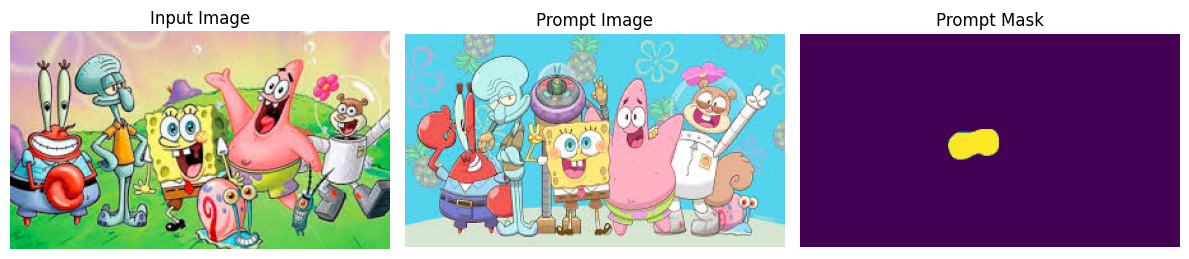

In [16]:
show_images_side_by_side(
    [image_input, image_prompt, mask_prompt],
    titles=["Input Image", "Prompt Image", "Prompt Mask"],
    cmap_list=[None, 'jet', None, 'jet']
)

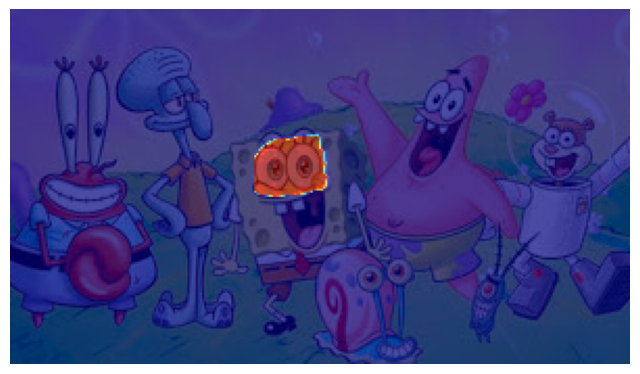

In [18]:
mask
show_segmentation_mask(image_input, mask, alpha=0.7)

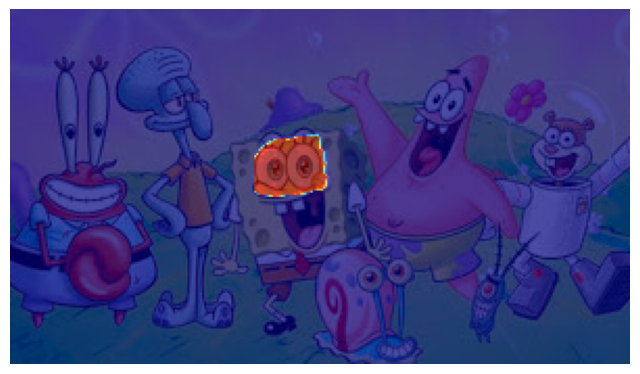

In [19]:
mask = seggpt(image_input, image_prompt, mask_prompt)

show_segmentation_mask(image_input, mask, alpha=0.7)